# Seol Bike Sharing Demand - Modeling

## Contents

1. [Read Data](#Read-Data)
2. [Train Test Split](#Train-Test-Split)
3. [Modeling](#Modeling)
    - [Linear Regression](#Linear-Regression)
    - [Ridge Regression](#Ridge-Regression)
    - [Lasso Regression](#Lasso-Regression)
    - [Decision Tree](#Decision-Tree)
    - [Random Forest](#Random-Forest)
    - [Gradient Boosting](#Gradient-Boosting)
    - [XGBoost](#XGBoost)
    - [LightGBM](#LightGBM)
    - [CatBoost](#CatBoost)
    - [Stacking](#Stacking)
4. [Final Model](#Final-Model)
5. [Conclusion](#Conclusion)

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import mlflow
from mlflow import log_metric, log_param, log_params, log_artifacts
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')
SEED = 42

## 1. Read Data

In [2]:
df_bike = pd.read_pickle("../input/processed/df_bike_encoded.pkl")
df_bike.head()

,rented_bike_count,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,year,...,hour_22,hour_23,seasons_Autumn,seasons_Spring,seasons_Summer,seasons_Winter,holiday_Holiday,holiday_No Holiday,functioning_day_No,functioning_day_Yes
0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,2017,...,0,0,0,0,0,1,0,1,0,1
1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,2017,...,0,0,0,0,0,1,0,1,0,1
2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,2017,...,0,0,0,0,0,1,0,1,0,1
3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,2017,...,0,0,0,0,0,1,0,1,0,1
4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,2017,...,0,0,0,0,0,1,0,1,0,1


## 2. Train Test Split

In [3]:
# Let's Keep aside 20% of the data for final testing
df_train, df_test = train_test_split(df_bike, test_size=0.2, random_state=SEED)

In [4]:
# Let's separate the features and target
X = df_train.drop(['rented_bike_count'], axis=1)
y = df_train['rented_bike_count']
print(X.shape, y.shape)

(7008, 48) (7008,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

## 3. Modeling

### 3.1 Linear Regression

In [6]:
# Create an experiment name, which must be unique and case sensitive
mlflow.set_tracking_uri(Path("../results/mlruns").resolve().as_uri())
experiment_name = "SeoulBikeSharing"
experiment_id = mlflow.create_experiment(
    experiment_name,
    tags={"version": "v1", "priority": "P1"},
    
)
experiment = mlflow.get_experiment(experiment_id=experiment_id)
print(f"Name: {experiment.name}")
print(f"Experiment_id: {experiment.experiment_id}")
print(f"Artifact Location: {experiment.artifact_location}")

MlflowException: Experiment 'SeoulBikeSharing' already exists.

In [7]:
# Function to calculate the metrics
def calc_metrics(y_test, y_pred, y_train, y_train_pred):
    # let's calculate the metrics for train and test
    rmse_test = mean_squared_error(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)
    rmse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)

    print("RMSE Test: ", np.sqrt(rmse_test))
    print("MAE Test: ", mae_test)
    print("RMSE Train: ", np.sqrt(rmse_train))
    print("MAE Train: ", mae_train)

    return rmse_test, mae_test, rmse_train, mae_train

In [8]:
# Function to plot the feature importance
def plot_feature_importance(importance, names, model_type):
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Create a DataFrame using a Dictionary
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    # Define size of bar plot
    plt.figure(figsize=(10, 8))
    # Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    # Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [9]:
# Function to plot the predictions
def plot_predictions(y_test, y_pred):
    plt.figure(figsize=(10, 8))
    plt.scatter(y_test, y_pred, c='crimson')
    plt.yscale('log')
    plt.xscale('log')

    p1 = max(max(y_pred), max(y_test))
    p2 = min(min(y_pred), min(y_test))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('Actual values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.title('Predictions vs Actuals')
    plt.show()

In [10]:
# Function to plot the learning curve
def plot_learning_curve(model, X, y, model_name):
    # Create learning curve
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, n_jobs=-1, verbose=1)
    # Calculate mean and standard deviation for training scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test scores
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 8))
    plt.title(f"{model_name} Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

In [11]:
# Function to plot the residuals
def plot_residuals(y_test, y_pred):
    plt.figure(figsize=(10, 8))
    sns.residplot(x=y_test, y=y_pred, lowess=True, color='g')
    plt.xlabel('Actual values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Actual')

### ML Flow Setup

In [12]:
# Function to apply the model with cross validation and plot the metrics
def apply_model(model, X_train, y_train, X_test, y_test, run_name):
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Handle negative values
    # y_pred[y_pred < 0] = 0

    # Calculate the metrics for train and test
    rmse_test, mae_test, rmse_train, mae_train = calc_metrics(y_test, y_pred, y_train, model.predict(X_train))

    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name=run_name):
        log_metric("rmse_test", rmse_test)
        log_metric("mae_test", mae_test)
        log_metric("rmse_train", rmse_train)
        log_metric("mae_train", mae_train)

    return model, y_pred

In [13]:
# Let's apply the Linear Regression model
lr = LinearRegression()
model, y_pred = apply_model(lr, X_train, y_train, X_test, y_test, "lr_model_1")

RMSE Test:  373.94504756797664
MAE Test:  282.9162946742526
RMSE Train:  372.2600509173422
MAE Train:  279.7344668087994


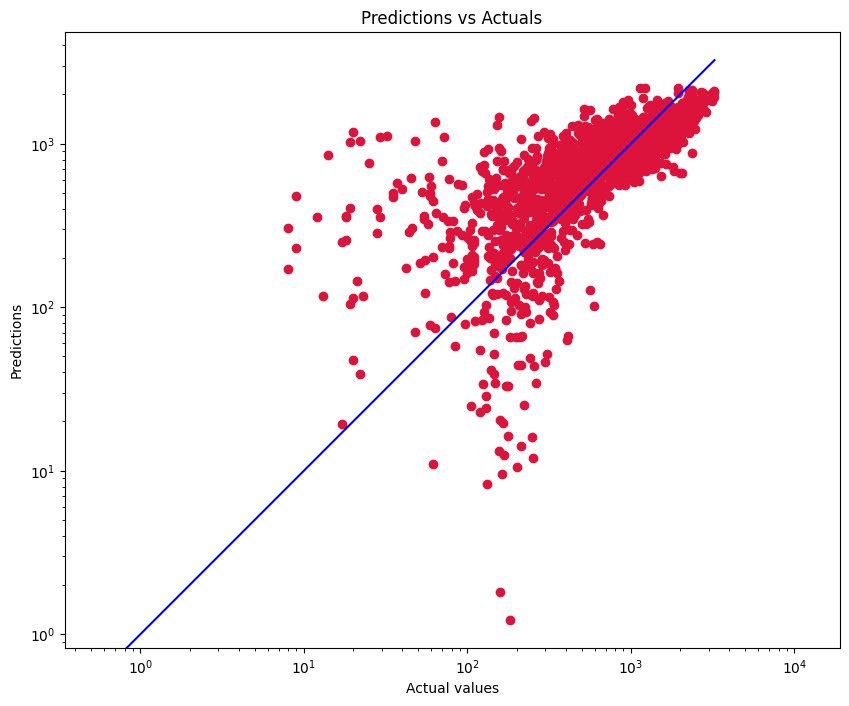

In [163]:
# Plot the predictions
plot_predictions(y_test, y_pred)

[learning_curve] Training set sizes: [ 420 1366 2312 3258 4204]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.1s finished


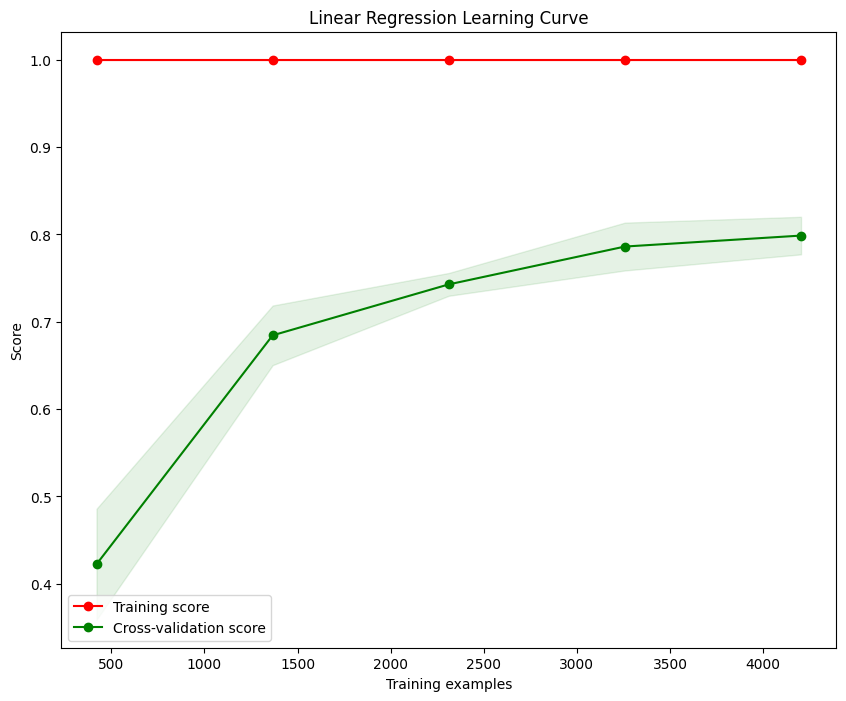

In [171]:
# Plot the learning curve
plot_learning_curve(model, X_train, y_train, "Linear Regression")

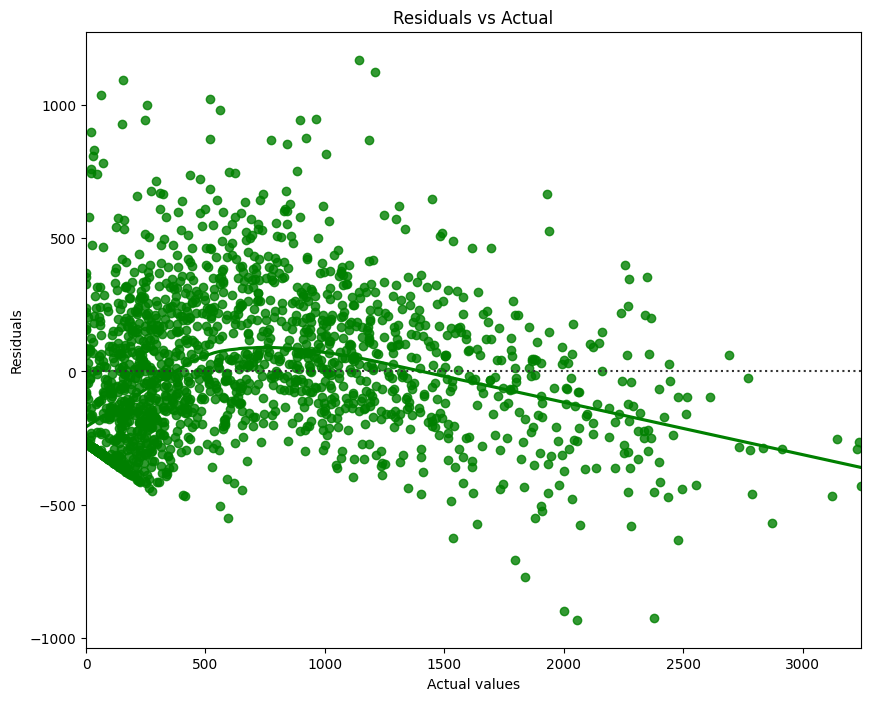

In [165]:
# Plot the residuals
plot_residuals(y_test, y_pred)

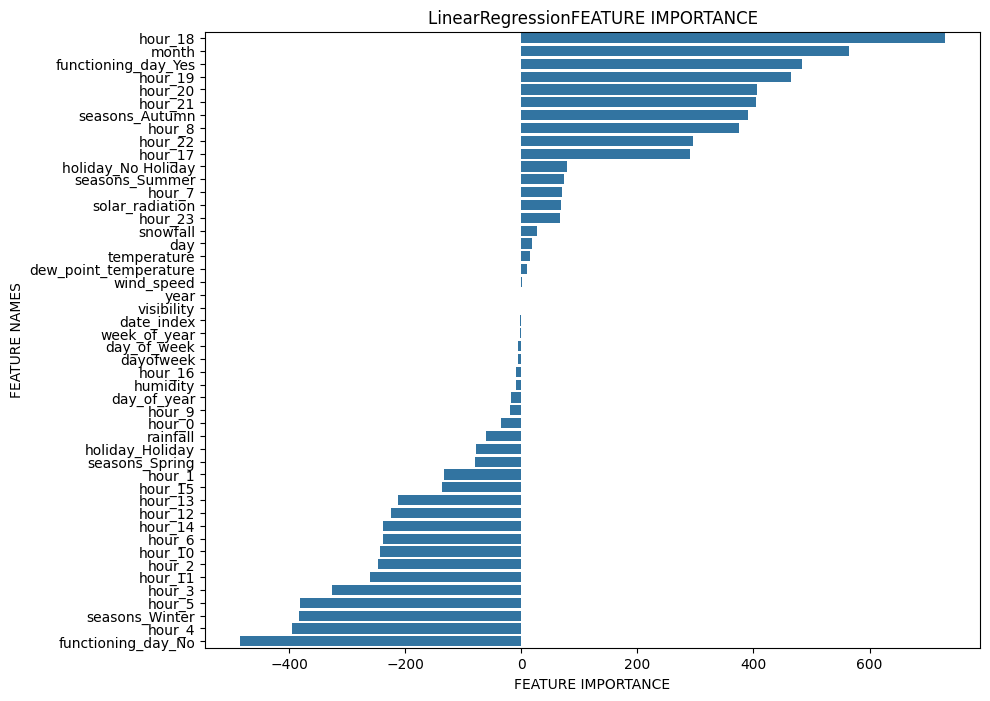

In [166]:
# Plot the feature importance
plot_feature_importance(model.coef_, X_train.columns, model.__class__.__name__)

In [123]:
# Let's drop the features with low importance, and apply the model again
def get_high_feat(model, X_train):
    # Create arrays from feature importance and feature names
    feature_importance = np.array(model.coef_)
    feature_names = np.array(X_train.columns)

    # Create a DataFrame using a Dictionary
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=True, inplace=True)

    # Let's select only the features with  -10 < importance < 10
    high_feat = fi_df[(fi_df['feature_importance'] > 10) | (fi_df['feature_importance'] < -10)]

    return high_feat

In [124]:
high_imp_feat = get_high_feat(model, X_train)

In [125]:
# Let's Keep only the high importance features
X_train_hf = X_train[high_imp_feat['feature_names']]

In [126]:
model, y_pred = apply_model(lr, X_train_hf, y_train, X_test[high_imp_feat['feature_names']], y_test, "lr_model_2")

MAE:  268.11291225206907
RMSE:  372.57185395335927


> The model performance reduced after selecting the high importance features.

Let's try drooping only dew_point_temperature as they are highly correlated.

In [130]:
model, y_pred = apply_model(lr, X_train.drop(columns=["dew_point_temperature"]), y_train, X_test.drop(columns=["dew_point_temperature"]), y_test, "lr_model_3")

MAE:  261.24765876179595
RMSE:  360.6412898224202


> functioning_day_Yes and functioning_day_No are contributing to the model significantly. Let's try removing them, as they are very intuitive features.

In [134]:
model, y_pred = apply_model(lr, X_train.drop(columns=["functioning_day_No", "functioning_day_Yes"]), y_train, X_test.drop(columns=["functioning_day_No", "functioning_day_Yes"]), y_test, "lr_model_3")

MAE:  284.8061894061382
RMSE:  394.26721336082034


> Dropping functioning_day_Yes and functioning_day_No reduced the model performance significantly. We will see further how they perform in the other models.

### 3.2 Ridge Regression

Let's try regression with regularization.

In [131]:
ridge = Ridge(alpha=0.1)
model, y_pred = apply_model(ridge, X_train, y_train, X_test, y_test, "ridge_model_1")

MAE:  260.8708037330322
RMSE:  360.2105005532539


> There is no improvement in the model performance.

### 3.3 Lasso Regression

Let's try Lasso regression.

In [132]:
lasso = Lasso(alpha=0.1)
model, y_pred = apply_model(lasso, X_train, y_train, X_test, y_test, "lasso_model_1")

MAE:  260.96640223904285
RMSE:  360.3482620386967


> Still no improvement in the model performance.

### 3.4 Decision Tree

In [196]:
%%time

from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=SEED)
model, y_pred = apply_model(dt, X_train, y_train, X_test, y_test, "dt_model_1")

RMSE Test:  289.19474979761003
MAE Test:  165.2574200913242
RMSE Train:  0.0
MAE Train:  0.0
CPU times: user 90 ms, sys: 5.98 ms, total: 96 ms
Wall time: 95.2 ms


> The model performance is sigficantly improved with Decision Tree.

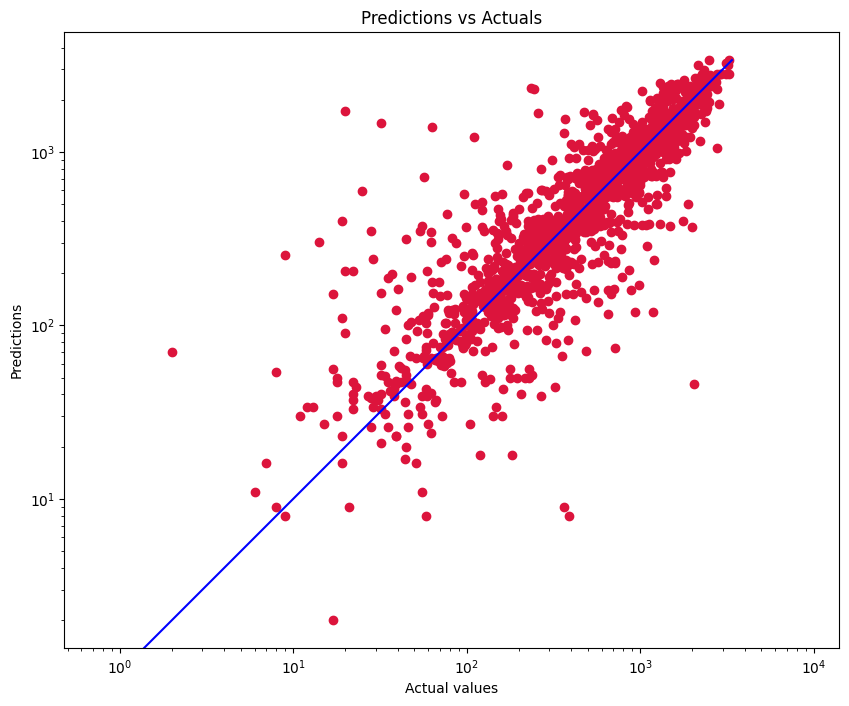

In [173]:
# Plot the predictions
plot_predictions(y_test, y_pred)

[learning_curve] Training set sizes: [ 420 1366 2312 3258 4204]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.3s finished


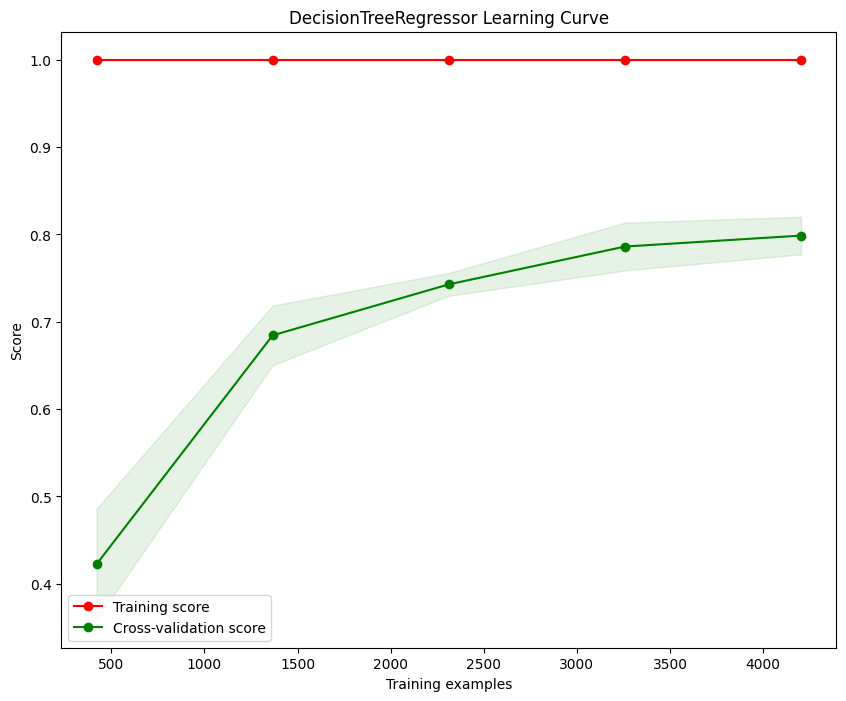

In [174]:
plot_learning_curve(model, X_train, y_train, "DecisionTreeRegressor")

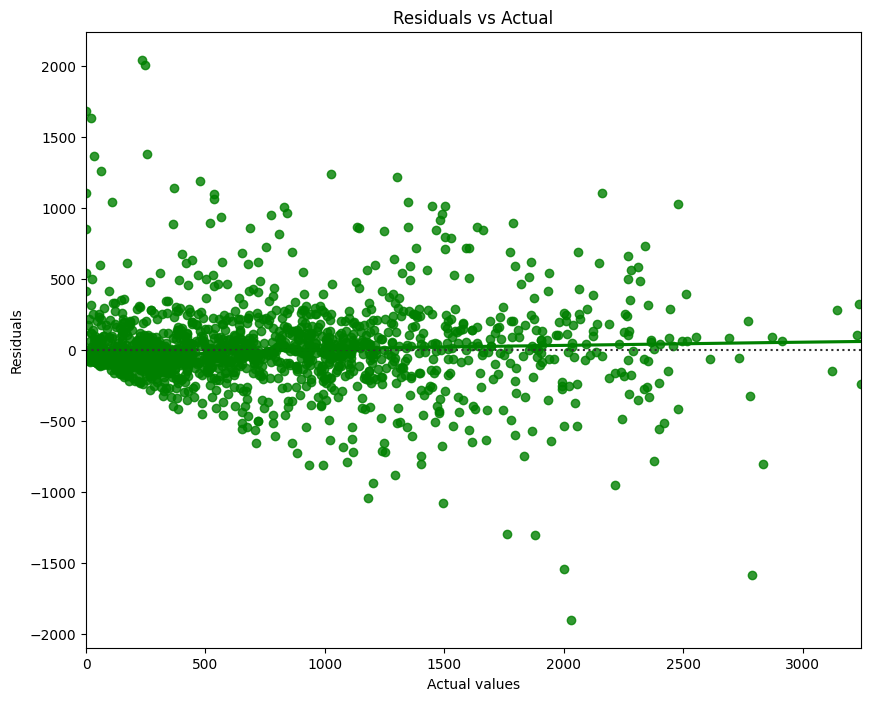

In [175]:
# Plot the residuals
plot_residuals(y_test, y_pred)

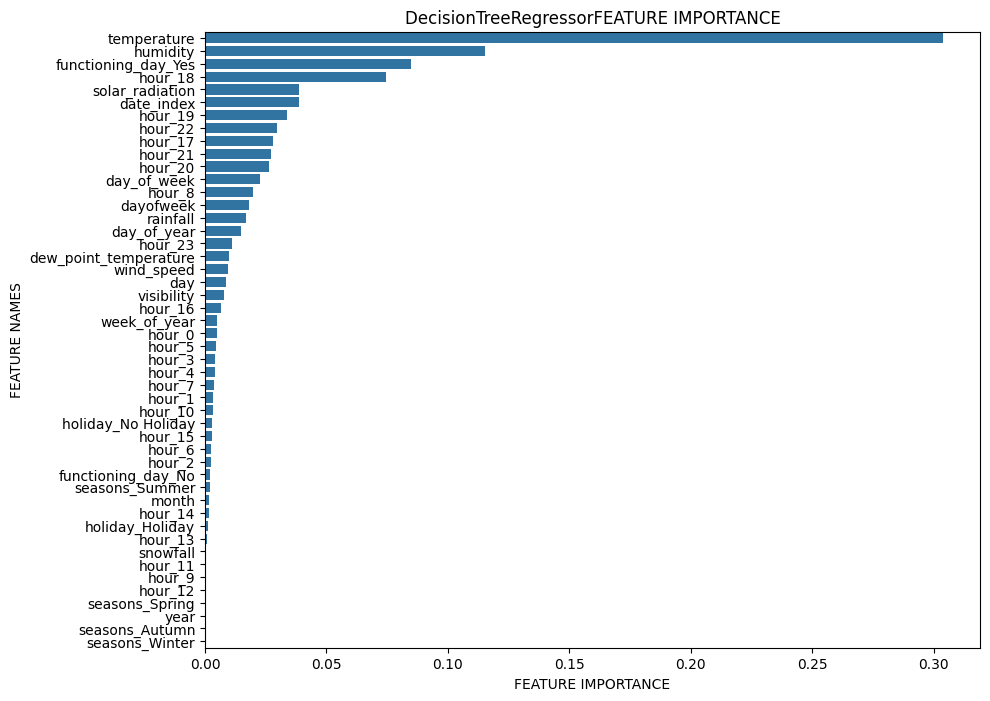

In [176]:
plot_feature_importance(model.feature_importances_, X_train.columns, model.__class__.__name__)

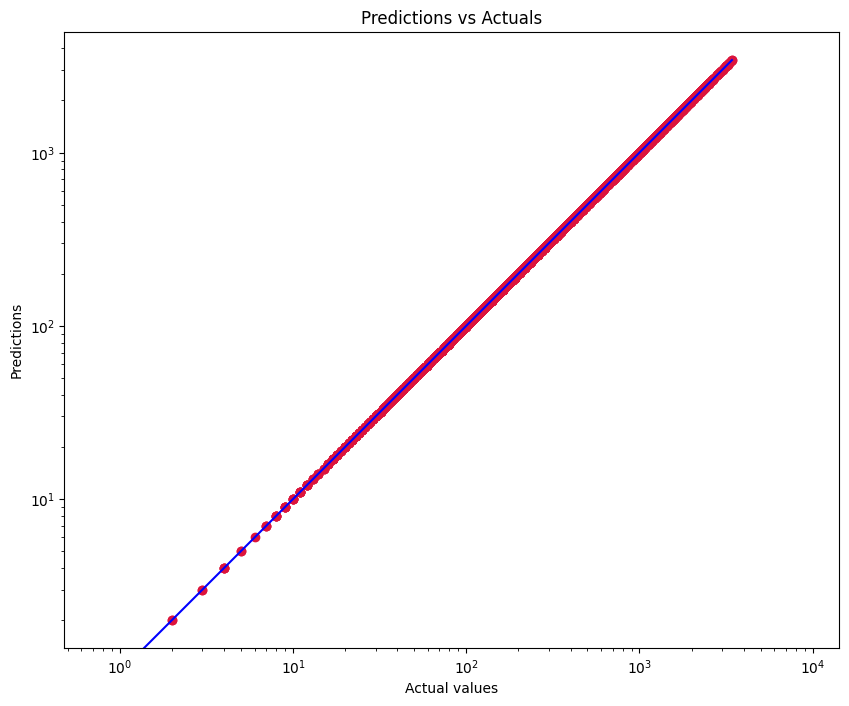

In [178]:
# Let's see the train predictions
y_train_pred = model.predict(X_train)
plot_predictions(y_train, y_train_pred)

> We can see the model is perfectly fitting the training data. We will tune the Decision Tree hyperparameters to avoid overfitting.

In [180]:
# Function to tune the Decision Tree Hyperparameters
def tune_dt(X_train, y_train, X_test, y_test):
    # Define the hyperparameters
    params = {
        'max_depth': np.arange(1, 20),
        'min_samples_split': np.arange(2, 10),
        'min_samples_leaf': np.arange(1, 10),
        'max_features': ['auto', 'sqrt', 'log2', None]
    }

    # Create a GridSearchCV object
    grid_search = GridSearchCV(estimator=dt, param_grid=params, cv=5, n_jobs=-1, verbose=1)

    # Fit the grid search object to the training data
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)

    # Create a model with the best hyperparameters
    model = DecisionTreeRegressor(**best_params)

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate the metrics for train and test
    rmse_test, mae_test, rmse_train, mae_train = calc_metrics(y_test, y_pred, y_train, model.predict(X_train))

    with mlflow.start_run(run_name="dt_model_tuned"):
        log_metric("rmse_test", rmse_test)
        log_metric("mae_test", mae_test)
        log_metric("rmse_train", rmse_train)
        log_metric("mae_train", mae_train)
        log_params(best_params)

    return model, y_pred, best_params

In [181]:
model, y_pred, best_params = tune_dt(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 5472 candidates, totalling 27360 fits
Best Hyperparameters: {'max_depth': 19, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
RMSE Test:  270.80729856545304
MAE Test:  160.6671245849706
RMSE Train:  154.30972015172776
MAE Train:  94.06240544911107


> The model performance is improved after tuning the hyperparameters. We are heading in the right direction.

### 3.5 Random Forest

In [216]:
%%time

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=SEED)
model, y_pred = apply_model(rf, X_train, y_train, X_test, y_test, "rf_model_1")

RMSE Test:  198.75198987071425
MAE Test:  114.74087328767123
RMSE Train:  72.41279946389747
MAE Train:  44.24400875190259
CPU times: user 4.2 s, sys: 7.07 ms, total: 4.2 s
Wall time: 4.21 s


In [220]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

> Nice: Random Forest is outperfotming the Decision Tree model. Let's tune the hyperparameters to further improve the model performance.

In [225]:
from sklearn.model_selection import RandomizedSearchCV
# Function to tune the Random Forest Hyperparameters
def tune_rf(rf, X_train, y_train, X_test, y_test):
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt', 'log2', None]
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(2, 50, num = 5)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [1, 2, 3, 4, 5]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 3, 4, 5, 6]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}
    print(random_grid)

    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the grid search object to the training data
    rf_random.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = rf_random.best_params_
    print("Best Hyperparameters:", best_params)

    # Make predictions
    y_pred = rf_random.predict(X_test)

    # Calculate the metrics for train and test
    rmse_test, mae_test, rmse_train, mae_train = calc_metrics(y_test, y_pred, y_train, rf_random.predict(X_train))

    with mlflow.start_run(run_name="rf_model_tuned"):
        log_metric("rmse_test", rmse_test)
        log_metric("mae_test", mae_test)
        log_metric("rmse_train", rmse_train)
        log_metric("mae_train", mae_train)
        log_params(best_params)

    return model, y_pred, best_params

In [226]:
%%time

model, y_pred, best_params = tune_rf(rf, X_train, y_train, X_test, y_test)

{'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt', 'log2', None], 'max_depth': [2, 14, 26, 38, 50, None], 'min_samples_split': [1, 2, 3, 4, 5], 'min_samples_leaf': [1, 2, 3, 4, 5, 6], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   0.0s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=26, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END boot

> We didn't see any improvement in the model performance after tuning the hyperparameters. So, we will stick with the default hyperparameters.

In [227]:
model, y_pred = apply_model(rf, X_train, y_train, X_test, y_test, "rf_model_2")

RMSE Test:  198.75198987071425
MAE Test:  114.74087328767123
RMSE Train:  72.41279946389747
MAE Train:  44.24400875190259


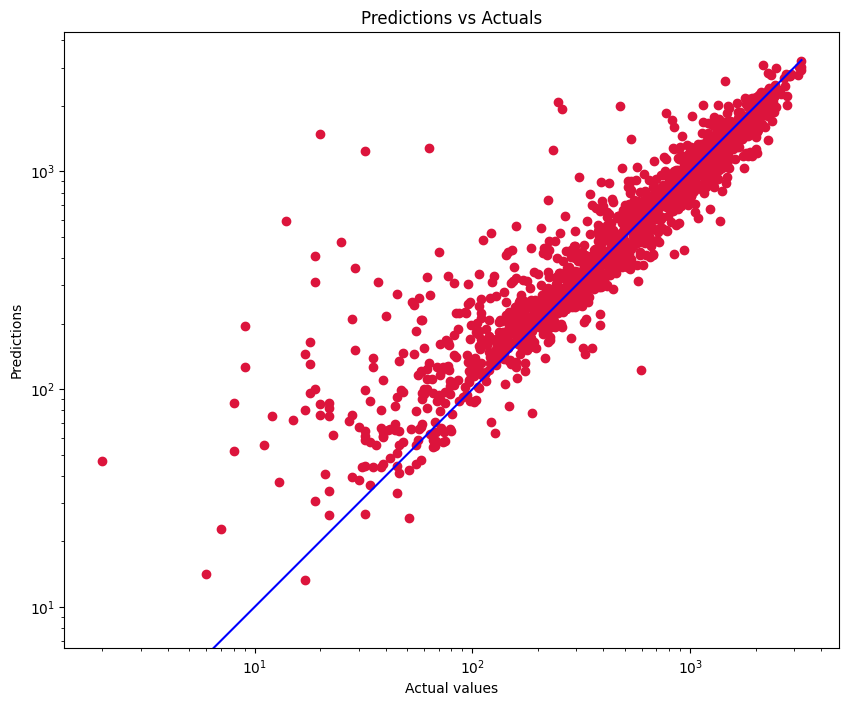

In [228]:
plot_predictions(y_test, y_pred)

[learning_curve] Training set sizes: [ 420 1366 2312 3258 4204]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   13.6s finished


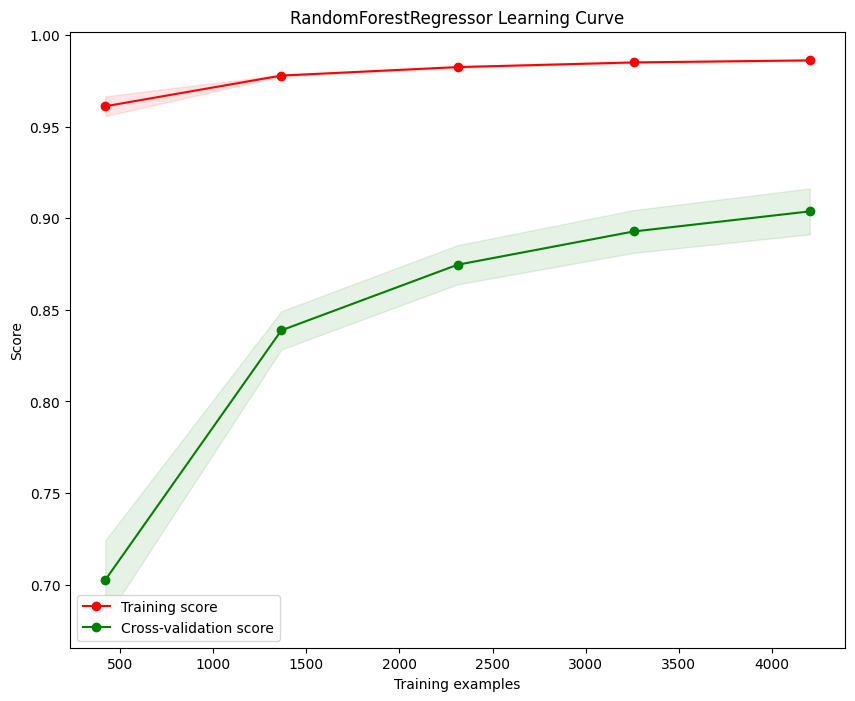

In [229]:
plot_learning_curve(model, X_train, y_train, "RandomForestRegressor")

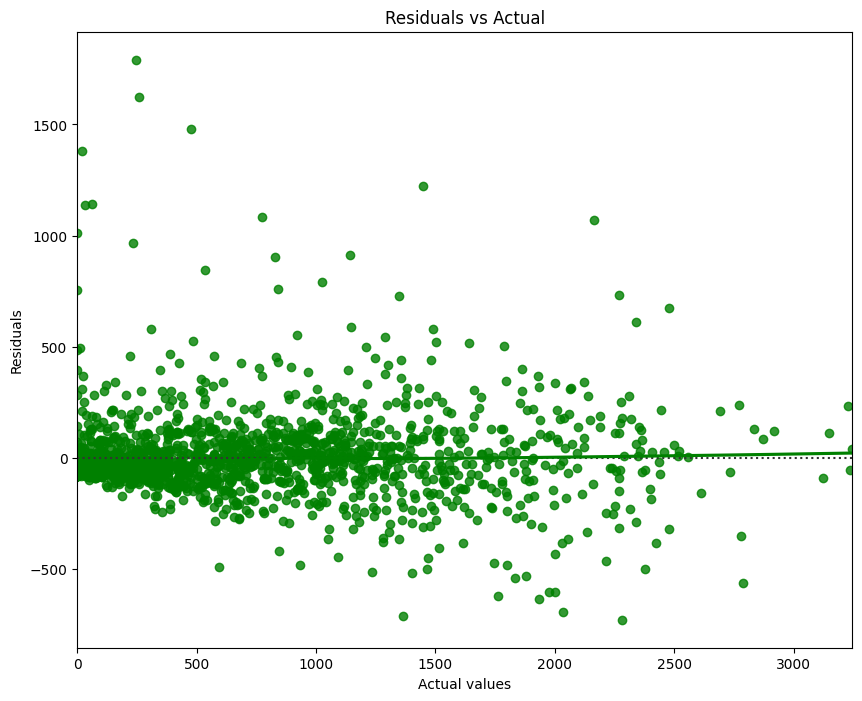

In [230]:
plot_residuals(y_test, y_pred)

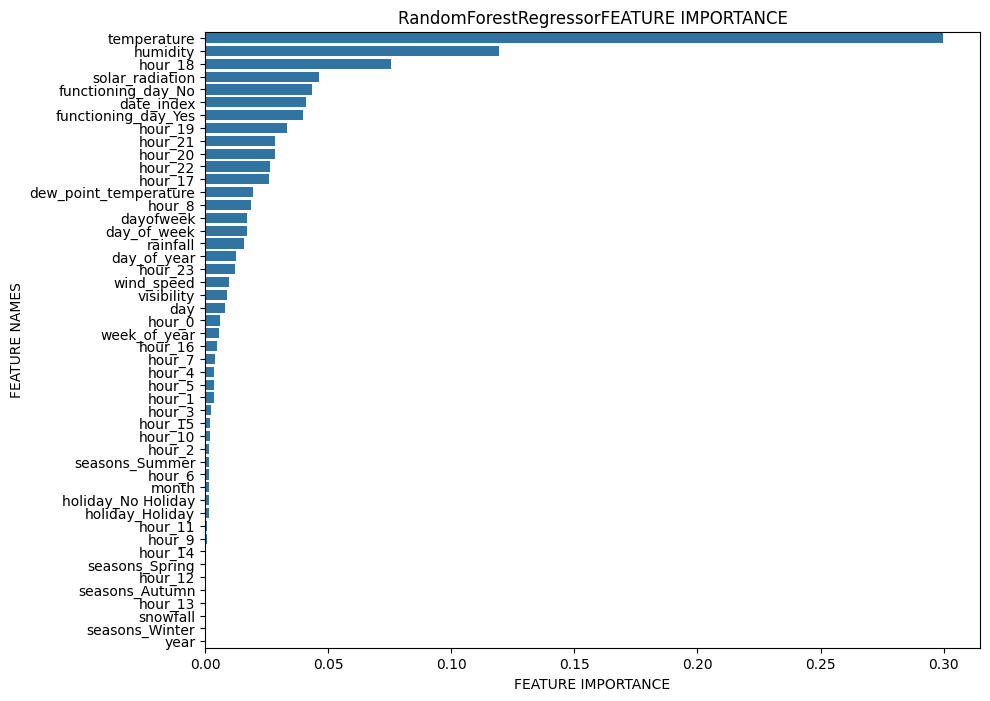

In [231]:
plot_feature_importance(model.feature_importances_, X_train.columns, model.__class__.__name__)

> Top features are similar to the Decision Tree model.

### 3.6 Gradient Boosting

In [232]:
# Let's apply the Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(random_state=SEED)
model, y_pred = apply_model(gb, X_train, y_train, X_test, y_test, "gb_model_1")

RMSE Test:  251.9816978957591
MAE Test:  179.06372490231942
RMSE Train:  243.43528096566274
MAE Train:  174.28063222899164


> The model performance reduced with Gradient Boosting.

### 3.7 XGBoost

In [14]:
# Let's apply the XGBoost Regressor
from xgboost import XGBRegressor
xgb = XGBRegressor(random_state=SEED)
model, y_pred = apply_model(xgb, X_train, y_train, X_test, y_test, "xgb_model_1")

RMSE Test:  175.5671291066265
MAE Test:  109.95306804408766
RMSE Train:  62.81114110426835
MAE Train:  43.193481434346424


In [15]:
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

> XGBoost is performing better than all the models we have tried so far. Let's tune the hyperparameters to further improve the model performance.

In [235]:
# Function to tune the XGBoost Hyperparameters
def tune_xgb(xgb, X_train, y_train, X_test, y_test):
    # Define the hyperparameters
    params = {
        'n_estimators': [50, 100, 250],
        'max_depth': [2, 3, 5, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.5, 0.7, 1],
        'gamma': [0, 0.1, 0.5, 1],
        'reg_alpha': [0, 0.1, 0.5, 1],
        'reg_lambda': [0, 0.1, 0.5, 1]
    }

    # Create a GridSearchCV object
    grid_search = GridSearchCV(estimator=xgb, param_grid=params, cv=5, n_jobs=-1, verbose=1)

    # Fit the grid search object to the training data
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)

    # Create a model with the best hyperparameters
    model = XGBRegressor(**best_params)

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate the metrics for train and test
    rmse_test, mae_test, rmse_train, mae_train = calc_metrics(y_test, y_pred, y_train, model.predict(X_train))

    with mlflow.start_run(run_name="xgb_model_tuned"):
        log_metric("rmse_test", rmse_test)
        log_metric("mae_test", mae_test)
        log_metric("rmse_train", rmse_train)
        log_metric("mae_train", mae_train)
        log_params(best_params)

    return model, y_pred, best_params

In [236]:
model, y_pred, best_params = tune_xgb(xgb, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 20736 candidates, totalling 103680 fits


KeyboardInterrupt: 